# Integrate GEX and ATAC annotation and Trajectory analysis

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import os

In [2]:
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
pd.options.display.max_columns=50

# Load ATAC and RNA

In [4]:
os.getcwd()

'/home/jovyan/project/notebooks/s1d2_analysis/final_notebooks'

In [5]:
os.chdir('/home/jovyan/project/notebooks/s1d2_analysis/')

In [6]:
adata_atac = sc.read('/home/jovyan/project/s1d2_data/s1d2_atac.h5ad')
adata_rna = sc.read('/home/jovyan/project/s1d2_data/s1d2_gex_annotated_v4_tidy.h5ad')

In [7]:
adata_rna

AnnData object with n_obs × n_vars = 7372 × 16946
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_9sub_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_atac

AnnData object with n_obs × n_vars = 7854 × 19039
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final'
    uns: 'neighbors', 'peak_names'
    obsm: 'lsi_full', 'lsi_red', 'peaks', 'umap'
    obsp: 'connectivities', 'distances'

# Merge datasets

Note on doublets: We filtered out doublet in the GEX processing. In ATAC data, doublet removal seems to be less successful. Therefore, we rely on the doublet detection in the GEX data and remove them by getting the cells shared between both data sets.

In [9]:
adata_rna.obs_names

Index(['AAACAGCCAACACTTG-2', 'AAACAGCCACCAGGTT-2', 'AAACAGCCAGTTAAAG-2',
       'AAACAGCCATAAGCAA-2', 'AAACAGCCATCCCTCA-2', 'AAACATGCAACTAGGG-2',
       'AAACATGCAACTGGCT-2', 'AAACATGCAAGATTCT-2', 'AAACATGCAATATGGA-2',
       'AAACATGCACAAAGCG-2',
       ...
       'TTTGTGGCACGTAAGG-2', 'TTTGTGGCATTGTCCT-2', 'TTTGTGTTCACAGGAA-2',
       'TTTGTGTTCATAACCA-2', 'TTTGTGTTCGATAACC-2', 'TTTGTGTTCGCCTGTT-2',
       'TTTGTGTTCTCATCAT-2', 'TTTGTTGGTACCGAAC-2', 'TTTGTTGGTCCGGTTC-2',
       'TTTGTTGGTTAGACCA-2'],
      dtype='object', length=7372)

In [10]:
#should end in -2
adata_atac.obs_names

Index(['AAACAGCCAACACTTG-1', 'AAACAGCCACCAGGTT-1', 'AAACAGCCAGTTAAAG-1',
       'AAACAGCCATAAGCAA-1', 'AAACAGCCATCCCTCA-1', 'AAACATGCAACTAGGG-1',
       'AAACATGCAACTGGCT-1', 'AAACATGCAAGATTCT-1', 'AAACATGCAATATGGA-1',
       'AAACATGCACAAAGCG-1',
       ...
       'TTTGTGGCACGTAAGG-1', 'TTTGTGGCATTGTCCT-1', 'TTTGTGTTCACAGGAA-1',
       'TTTGTGTTCATAACCA-1', 'TTTGTGTTCGATAACC-1', 'TTTGTGTTCGCCTGTT-1',
       'TTTGTGTTCTCATCAT-1', 'TTTGTTGGTACCGAAC-1', 'TTTGTTGGTCCGGTTC-1',
       'TTTGTTGGTTAGACCA-1'],
      dtype='object', length=7854)

In [11]:
# corrects adata_atac barcodes to end with -2 
adata_atac.obs['corrected_barcodes'] = [name.replace('-1','-2') for name in adata_atac.obs_names.values]

In [12]:
adata_atac.obs_names = adata_atac.obs['corrected_barcodes']

In [13]:
adata_atac.obs_names

Index(['AAACAGCCAACACTTG-2', 'AAACAGCCACCAGGTT-2', 'AAACAGCCAGTTAAAG-2',
       'AAACAGCCATAAGCAA-2', 'AAACAGCCATCCCTCA-2', 'AAACATGCAACTAGGG-2',
       'AAACATGCAACTGGCT-2', 'AAACATGCAAGATTCT-2', 'AAACATGCAATATGGA-2',
       'AAACATGCACAAAGCG-2',
       ...
       'TTTGTGGCACGTAAGG-2', 'TTTGTGGCATTGTCCT-2', 'TTTGTGTTCACAGGAA-2',
       'TTTGTGTTCATAACCA-2', 'TTTGTGTTCGATAACC-2', 'TTTGTGTTCGCCTGTT-2',
       'TTTGTGTTCTCATCAT-2', 'TTTGTTGGTACCGAAC-2', 'TTTGTTGGTCCGGTTC-2',
       'TTTGTTGGTTAGACCA-2'],
      dtype='object', name='corrected_barcodes', length=7854)

In [14]:
common_barcodes = list(set(adata_rna.obs_names).intersection(adata_atac.obs_names))
adata_rna_sub = adata_rna[common_barcodes].copy()
adata_atac_sub = adata_atac[common_barcodes].copy()

In [15]:
adata_rna_sub.obs['atac_ann'] = adata_atac_sub.obs['leiden_final']
adata_atac_sub.obs['rna_ann'] = adata_rna_sub.obs['leiden_final']

# Merge leiden_finals

Here, we plot the celltype annotation based on the two modalities on the UMAP representation of each. Thereby we can assess how well the annotation of one modality matches the data structure in the other modality. This gives us a first overview where one modality containes additional substructure compared to the other.

For each celltype, we try to find the modality the represents a cleaner and more fine grained clustering. E.g. for T cells, the clusters are better separated in the ATAC data (CD4+ vs CD8+), while for B cells additional substructure is found in the GEX data (see how the Transitional B cell cluster from ATAC is sparated into two distant clusters in the GEX data).

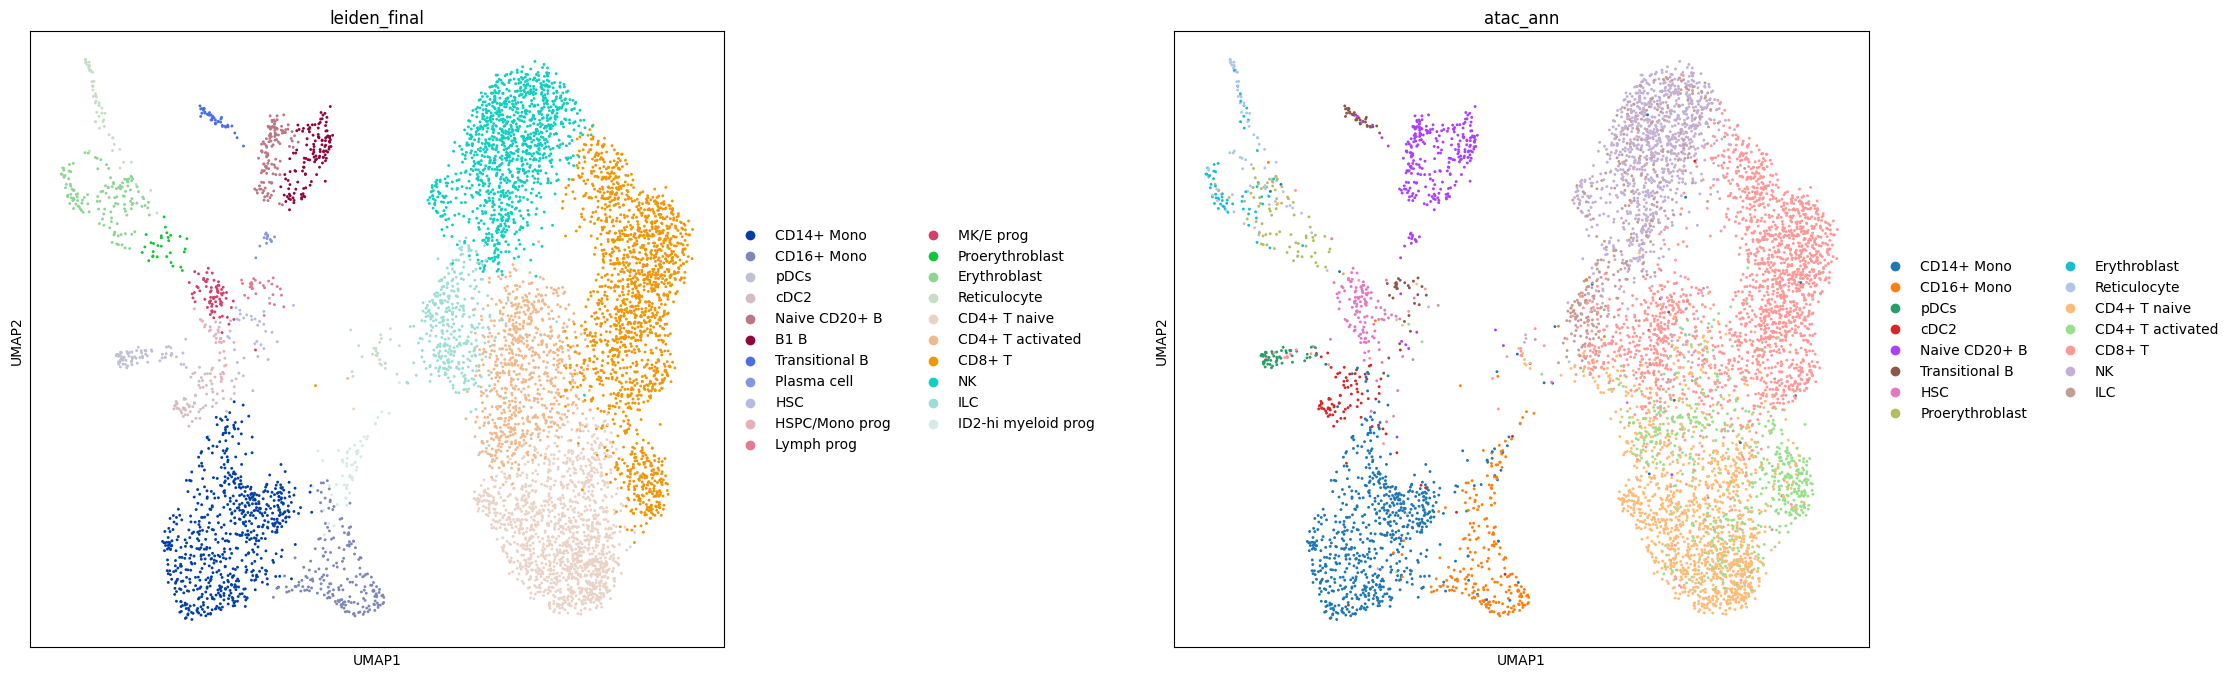

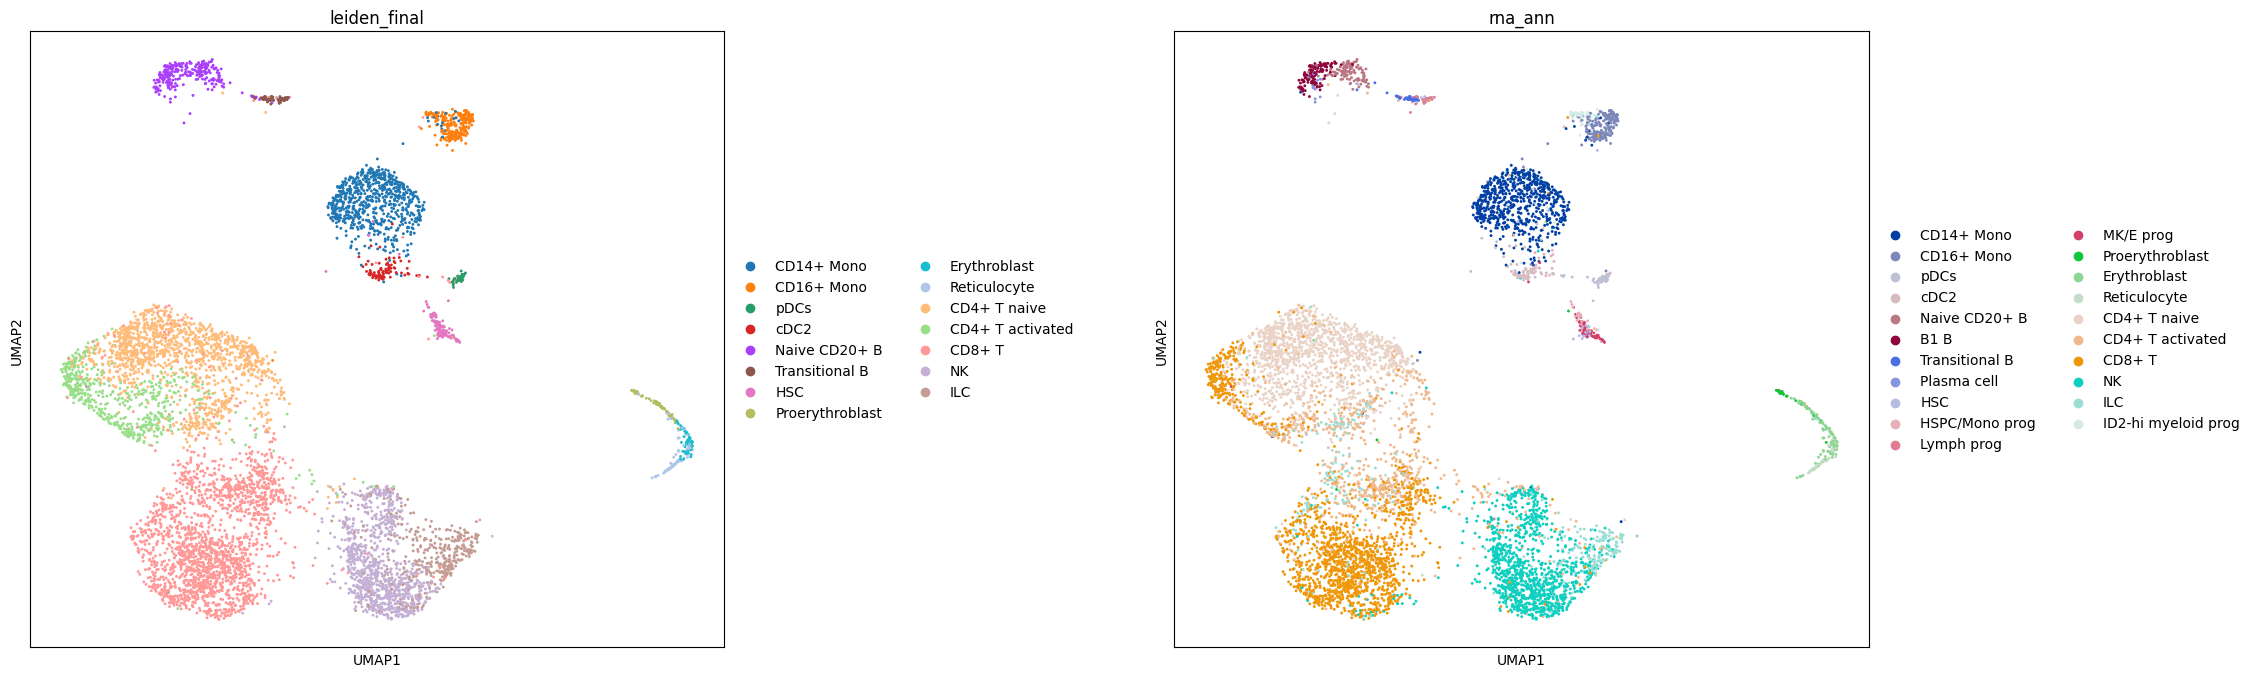

In [16]:
sc.pl.umap(adata_rna_sub, color=['leiden_final', 'atac_ann'], wspace=0.5)
sc.pl.umap(adata_atac_sub, color=['leiden_final', 'rna_ann'], wspace=0.5)

We then decide which modality should be the more determining one for each cell type:
- B cell leiden_finals better in RNA
- Erythrocytes/reticulocytes better in RNA
- Monocytes better in RNA or ATAC
- Progenitors better in RNA
- T cells better in RNA
- NK cells better in ATAC

## Crosstab leiden_finals

We now dive into details and check which cell type in one modality corresponds to the celltype in the second.

We look for differing annotations and check those with marker genes for each modality below. Thereby, we take a final decision for each celltype, which annotation we will use.

In [17]:
# Note: First argument corresponds to rows (here, RNA), second argument to columns (here: ATAC)
pd.crosstab(adata_rna_sub.obs['leiden_final'], adata_atac_sub.obs['leiden_final'])

leiden_final         CD14+ Mono  CD16+ Mono  pDCs  cDC2  Naive CD20+ B  \
leiden_final                                                             
CD14+ Mono                  646           7     0    11              1   
CD16+ Mono                   14         179     1     1              0   
pDCs                          1           0    51     4              0   
cDC2                          4           0     1    67              0   
Naive CD20+ B                 0           0     0     0            121   
B1 B                          0           0     0     0            127   
Transitional B                0           0     0     0              6   
Plasma cell                   0           0     0     0             13   
HSC                           0           1     0     0              4   
HSPC/Mono prog                5           0     0     3              0   
Lymph prog                    0           0     0     0              1   
MK/E prog                     1           0     0     1              0   
Proerythroblast               0           0     0     0              0   
Erythroblast                  1           0     0     0              0   
Reticulocyte                  4           2     0     0              2   
CD4+ T naive                  2           0     0     0              1   
CD4+ T activated              0           0     0     0              1   
CD8+ T                        2           1     0     0              0   
NK                            4           0     0     1              0   
ILC                           3           3     0     0              0   
ID2-hi myeloid prog          17          40     0     1              0   

leiden_final         Transitional B  HSC  Proerythroblast  Erythroblast  \
leiden_final                                                              
CD14+ Mono                        0    1                0             0   
CD16+ Mono                        0    0                0             0   
pDCs                              0    2                0             0   
cDC2                              0    1                0             0   
Naive CD20+ B                     0    0                0             0   
B1 B                              0    0                0             0   
Transitional B                   34    0                0             0   
Plasma cell                       0    0                0             0   
HSC                               5   18                0             0   
HSPC/Mono prog                    0   27                0             0   
Lymph prog                       23    1                0             0   
MK/E prog                         0   69                1             0   
Proerythroblast                   0    1               25             1   
Erythroblast                      0    0               48            48   
Reticulocyte                      0    0                0            11   
CD4+ T naive                      0    0                0             0   
CD4+ T activated                  3    1                1             0   
CD8+ T                            1    0                0             0   
NK                                0    0                0             0   
ILC                               0    1                0             0   
ID2-hi myeloid prog               0    0                0             0   

leiden_final         Reticulocyte  CD4+ T naive  CD4+ T activated  CD8+ T  \
leiden_final                                                                
CD14+ Mono                      0             2                 1       1   
CD16+ Mono                      0             0                 0       0   
pDCs                            0             0                 0      12   
cDC2                            0             0                 0       1   
Naive CD20+ B                   0             0                 0       0   
B1 B                            

### Load marker genes

In case in your analysis other markers showed up, we can add them here as well

In [18]:
#RNA
marker_genes_rna = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'CRACD', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers
    'NK': ['GNLY', 'NKG7', 'CD247', 'GRIK4'],
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],
    'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
    'B1 B': ['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'IGHD', 'IGHM'], # Note IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA'],
    'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'],
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'],
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1']
}

#ATAC
marker_genes_atac = {
    'CD14+ Mono': ['TREM1', 'FPR1'],
    'CD16+ Mono': ['LYN', 'TCF7L2'],
    'ID2-hi myeloid prog': ['KLF4'],
    'cDC2': ['TREM1', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['GATA1', 'HBA1', 'SLC4A1', 'SLC25A37', 'KLF1'],
    'Erythroblast': ['GATA1', 'MKI67'],
    'Proerythroblast': ['GATA2', 'CRACD', 'SYNGR1'],
    'NK': ['CD160', 'GNLY', 'GRIK4', 'CD247'],
    'ILC': ['SPON2', 'GZMB', 'PRF1', 'C69'], # Note CD69 should be negative
    'Lymph prog': ['MME', 'IGLL1', 'VPREB1', 'CD79B'],
    'Naive CD20+ B': ['MS4A1', 'LYN', 'CD74', 'BLK'],
    'B1 B': ['ITGB1', 'MS4A1', 'DUSP22', 'EPHA4'],
    'Transitional B': ['MME', 'CD38', 'CD24'],
    'Plasma cells': ['DUSP22', 'FNDC3B'],
    'CD4+ T activated': ['JAKMIP1', 'C4orf50'],
    'CD4+ T naive': [ 'BCL11B', 'BACH2', 'JAKMIP1', 'C4orf50'], # Note JAKMIP1 and C4orf50 are negative markers
    'CD8+ T': ['CD8A', 'CD8B'],
    'pDCs': ['PTPRS', 'TCF4', 'KCNN3', 'DUSP22'],
    'G/M prog': ['MPO','NT5DC3'],
    'HSC': ['PRDM16','TAMALIN','MTRNR2L1'],
    'MK/E prog': ['DNAJC6']
}


**Which annotation to be used per celltype**

(Plotting specific marker genes for clarification below)

From RNA:
- Reticulocyte
- Erythroblast
- Proerythroblast
- Lymph prog
- Naive CD20+ B
- B1 B
- Transitional B
- Plasma cells
- CD4+ T activated
- CD4+ T naive

From ATAC:
- CD14+ Mono
- CD16+ Mono
- CD8+ T
- pDCs
- cDC2
- NK
- ILC

### Check out specific celltypes

Check out cell type markers in each modality to see which clusters are more disctinct. Here we plot RNA and ATAC markers on both representations.

Markers on RNA


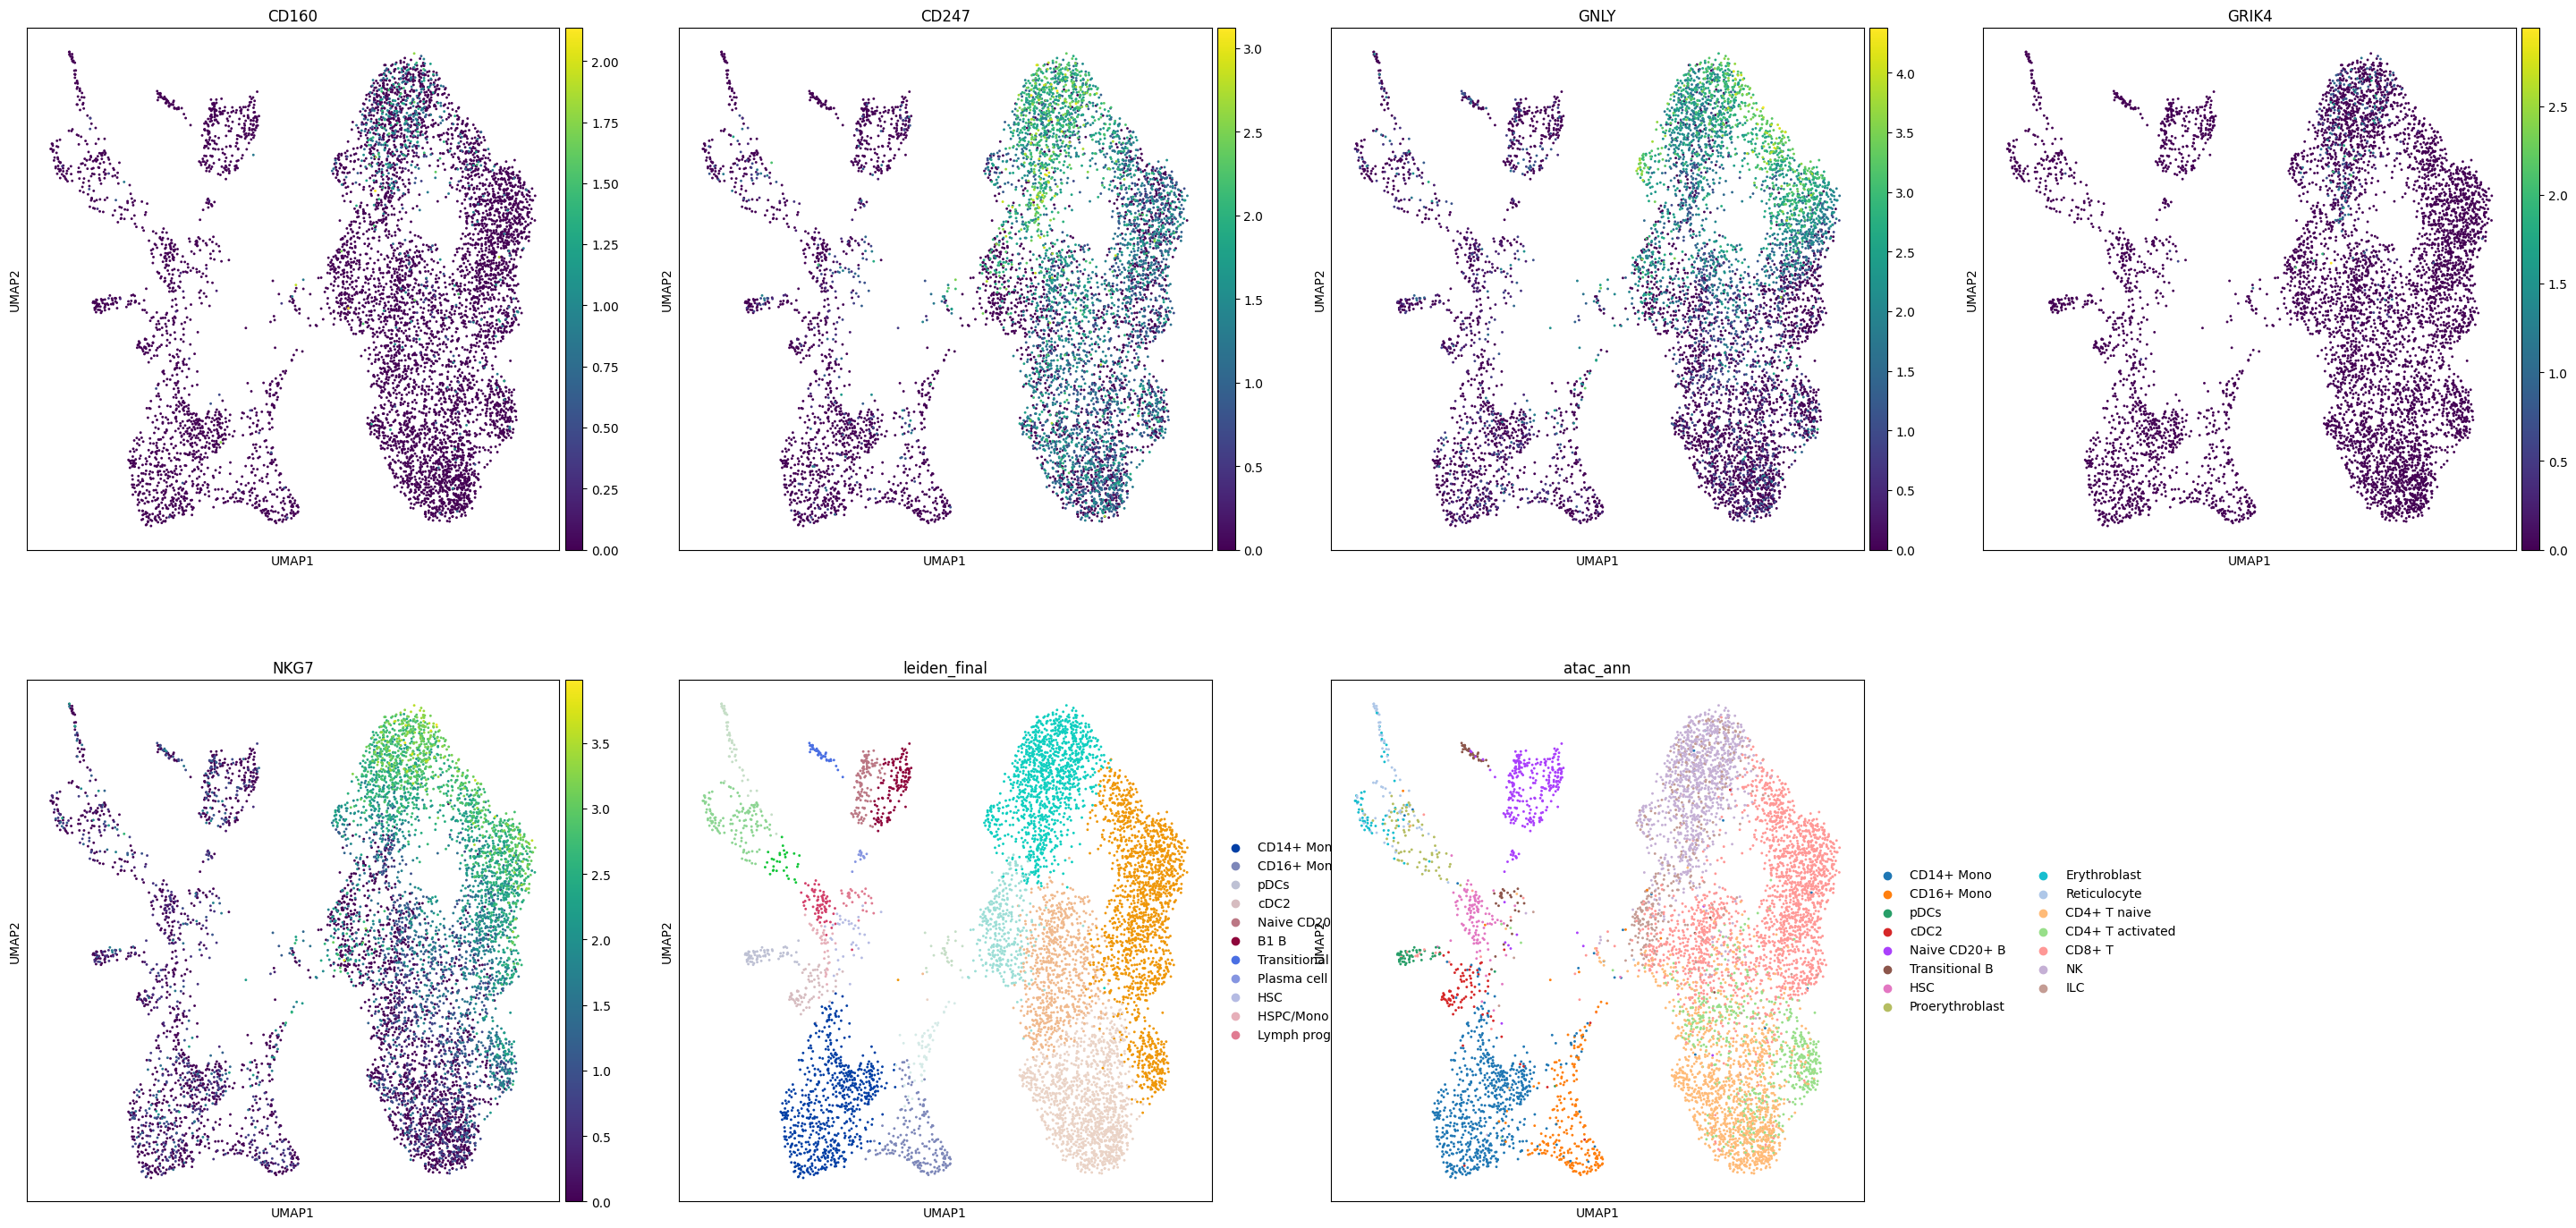

Markers on ATAC


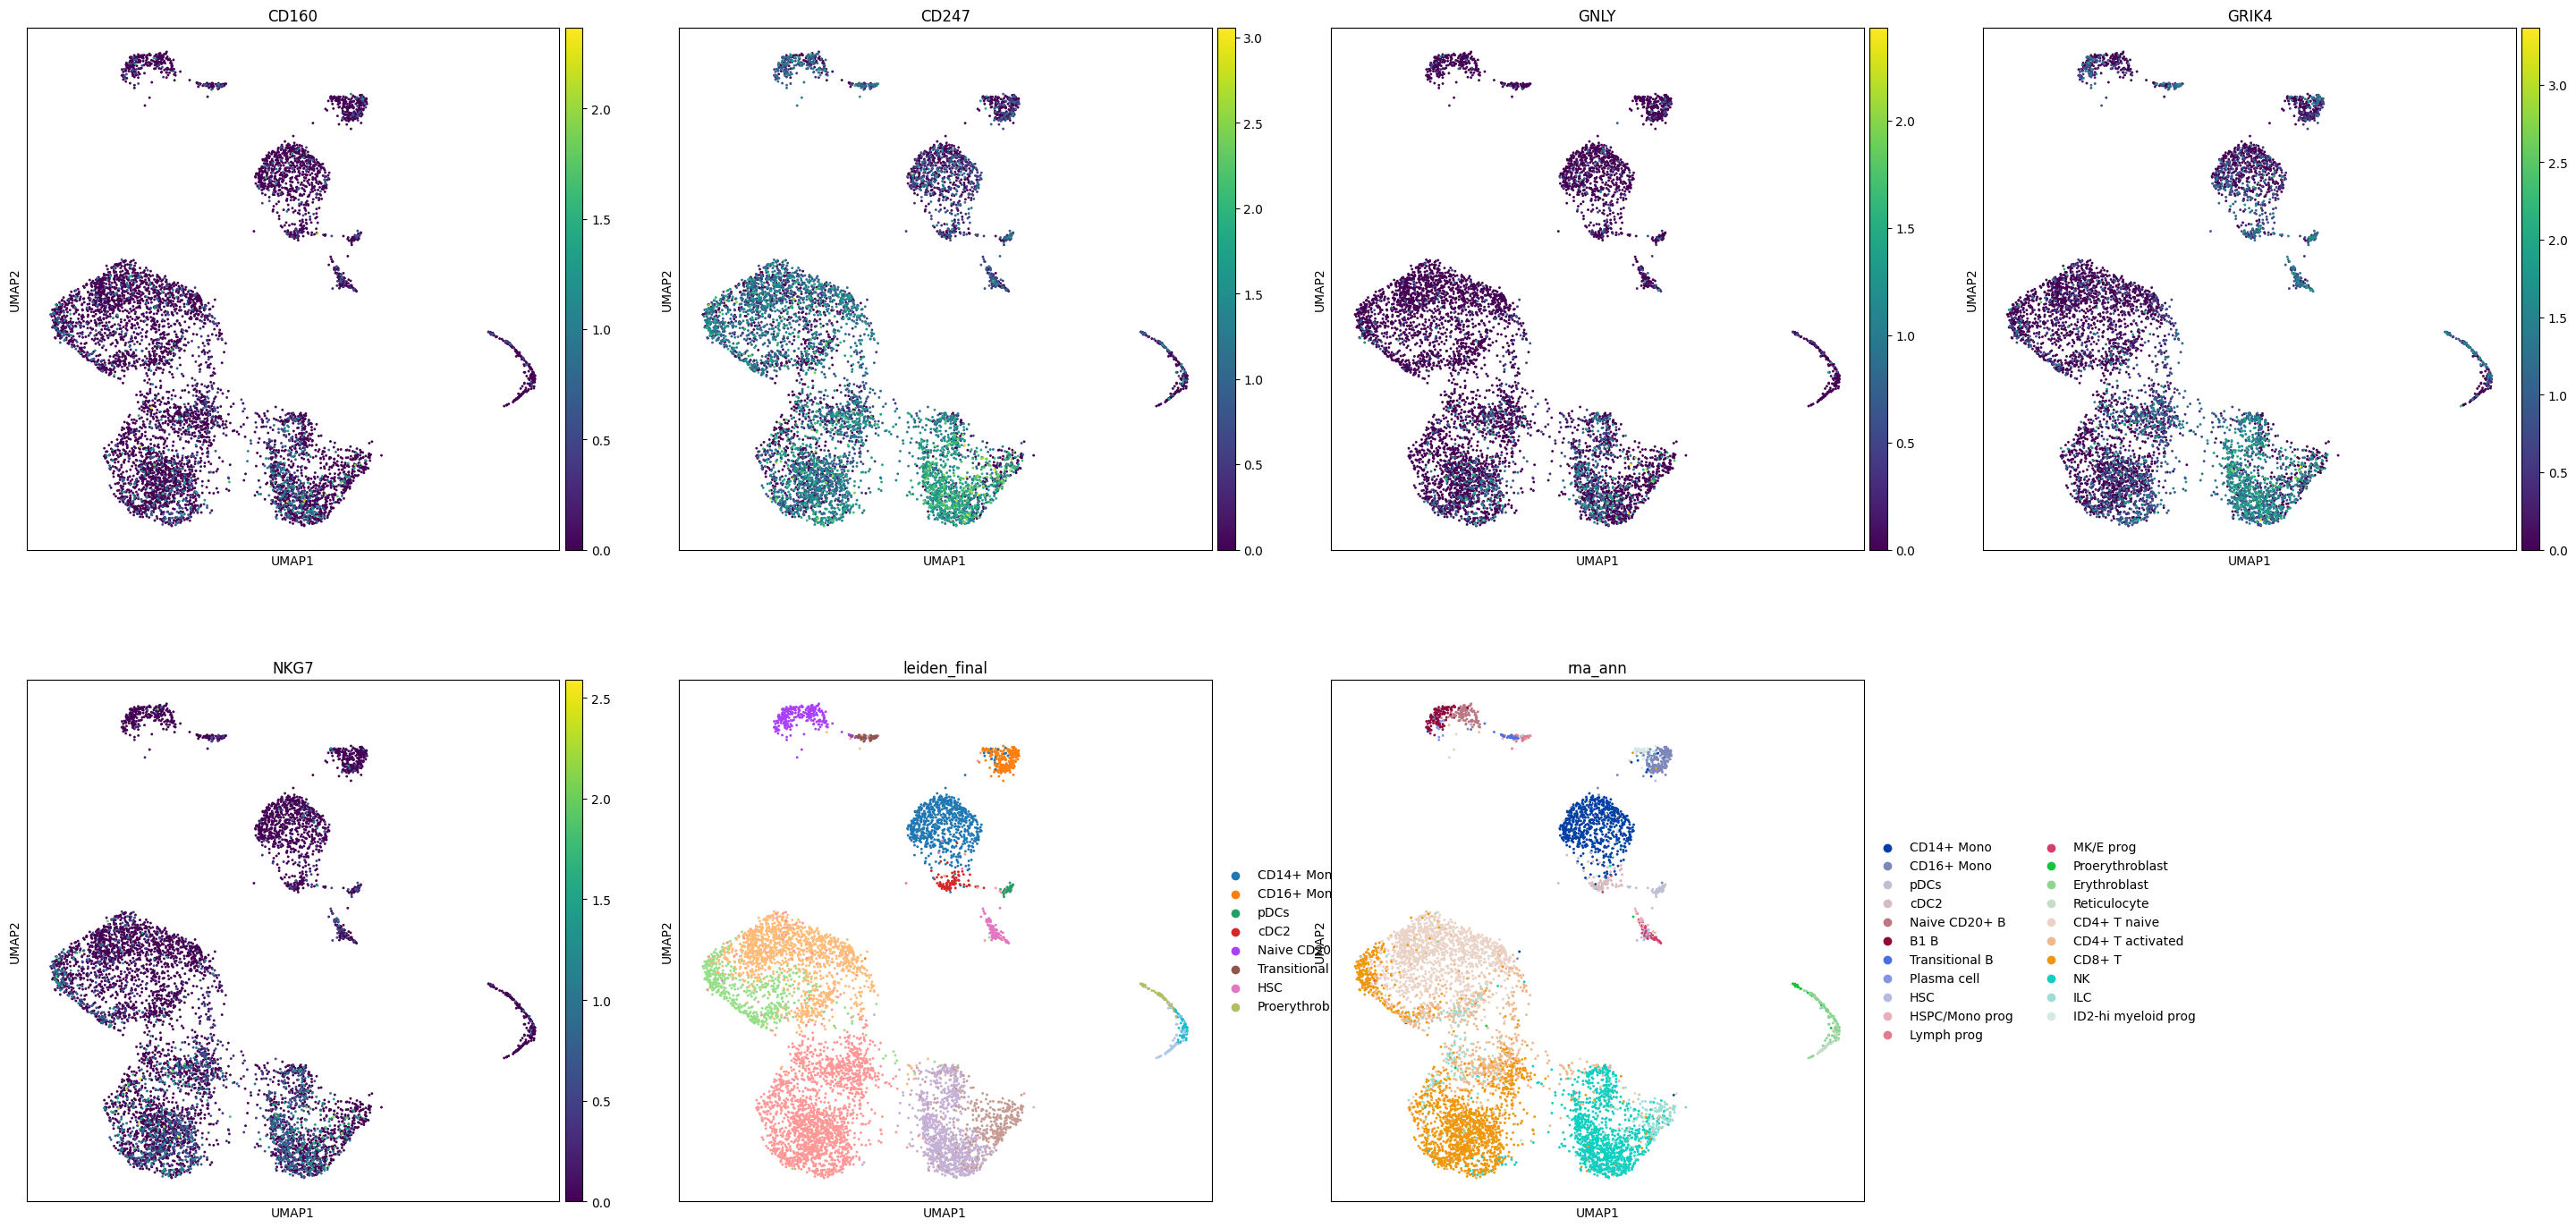

In [19]:
# select celltypes to compare
rna_ct = 'NK'
atac_ct = 'NK'

genes = marker_genes_rna[rna_ct]+marker_genes_atac[atac_ct]
ann_key_r = 'leiden_final'
ann_key_a = 'leiden_final'

genes_r = [g for g in adata_rna_sub.var_names if str(g) in genes ]
genes_a = [g for g in adata_atac_sub.var_names if str(g) in genes]

print('Markers on RNA')
sc.pl.umap(adata_rna_sub, color=genes_r+[ann_key_r, 'atac_ann'])

print('Markers on ATAC')
sc.pl.umap(adata_atac_sub, color=genes_a+[ann_key_a, 'rna_ann'])

if len(genes) < 3:
    plt.rcParams['figure.figsize'] = (24,8)
    sc.pl.violin(adata_atac_sub, keys=genes_a, groupby=ann_key_a)
    plt.rcParams['figure.figsize'] = (8,8)

Additional highlighting of selected clusters (e.g. in case you can't identify particular clusters from the ATAC or RNA plots due to bad coloring)

... storing 'test' as categorical


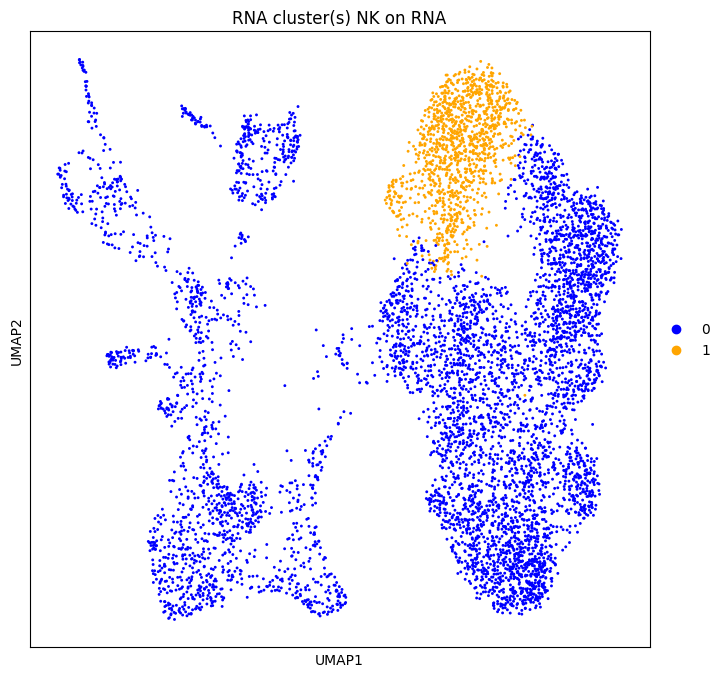

... storing 'test' as categorical


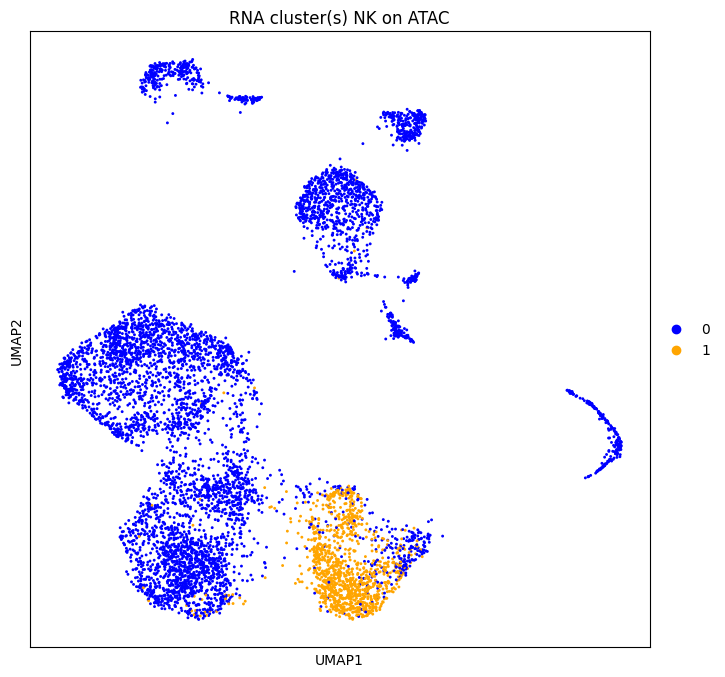

... storing 'test' as categorical


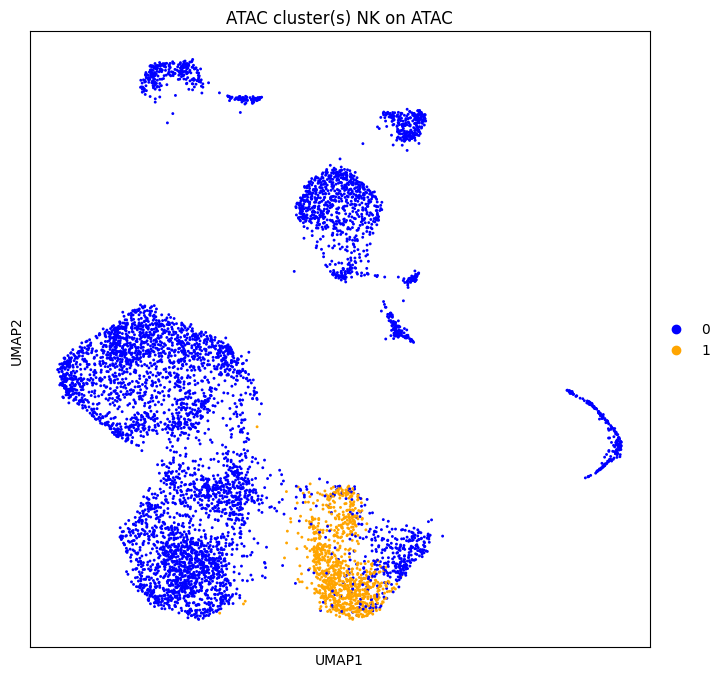

... storing 'test' as categorical


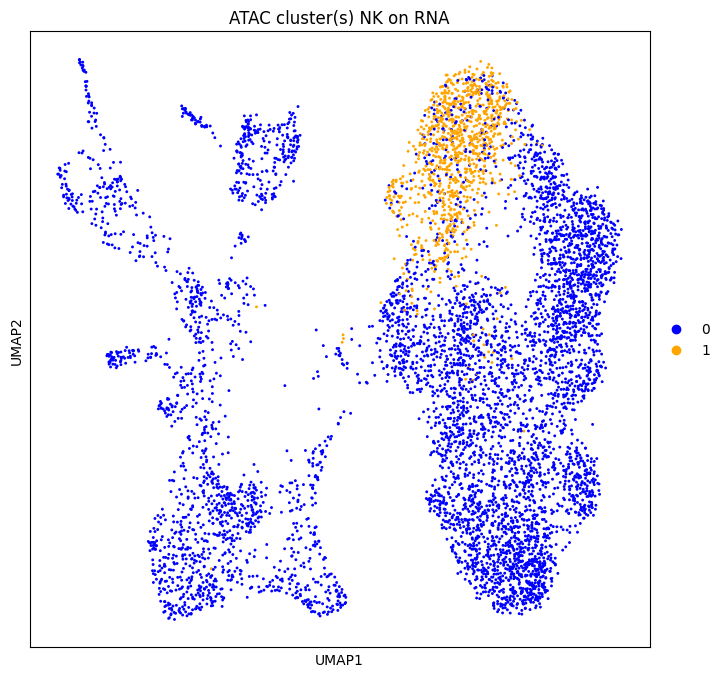

In [20]:
#RNA clusters
#-------------
# Use celltype from above
clusts = [rna_ct]
# Or selct new ones
#clusts = ['HSPC/Lymph prog?']

adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['leiden_final']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on RNA')
adata_atac_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_atac_sub.obs['rna_ann']]
sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on ATAC')


#ATAC clusters
#--------------
# Use celltype from above
clusts = [atac_ct]
# Or selct new ones
#clusts = ['HSPC']

adata_atac_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_atac_sub.obs['leiden_final']]
sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'ATAC cluster(s) '+ '; '.join(clusts) + ' on ATAC')
adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['atac_ann']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'ATAC cluster(s) '+ '; '.join(clusts) + ' on RNA')



## Create a final merged celltype annotation

In [21]:
# List RNA celltypes
set(adata_rna_sub.obs['leiden_final'])

{'B1 B',
 'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T naive',
 'CD8+ T',
 'Erythroblast',
 'HSC',
 'HSPC/Mono prog',
 'ID2-hi myeloid prog',
 'ILC',
 'Lymph prog',
 'MK/E prog',
 'NK',
 'Naive CD20+ B',
 'Plasma cell',
 'Proerythroblast',
 'Reticulocyte',
 'Transitional B',
 'cDC2',
 'pDCs'}

In [22]:
# List ATAC celltypes
set(adata_atac_sub.obs['leiden_final'])

{'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T naive',
 'CD8+ T',
 'Erythroblast',
 'HSC',
 'ILC',
 'NK',
 'Naive CD20+ B',
 'Proerythroblast',
 'Reticulocyte',
 'Transitional B',
 'cDC2',
 'pDCs'}

In [23]:
# Chose celltype from each modality:

celltype_map_rna = {
    'Reticulocyte':'Reticulocyte',
    'Erythroblast':'Erythroblast',
    'Proerythroblast':'Proerythroblast',
    'Lymph prog':'Lymph prog',
    'Naive CD20+ B':'Naive CD20+ B',
    'B1 B': 'B1 B',
    'Transitional B':'Transitional B',
    'Plasma cell':'Plasma cell',
    'HSPC':'G/M prog',
    'HSC':'HSC',
    'MK/E prog':'MK/E prog',
    'HSPC/Mono prog':'HSPC/Mono prog',
    'CD4+ T activated':'CD4+ T activated',
    'CD4+ T naive':'CD4+ T naive',
    'CD8+ T':'CD8+ T',
    'CD16+ Mono':'CD16+ Mono',
    'ID2-hi myeloid prog':'ID2-hi myeloid prog'
}

celltype_map_atac = {
    'CD14+ Mono':'CD14+ Mono',
    'pDCs':'pDCs',
    'cDC2':'cDC2',
    'NK':'NK',
    'ILC':'ILC'
}

rna_cts = list(celltype_map_rna.keys())
atac_cts = list(celltype_map_atac.keys())

Create new colomn with selected celltypes and add **'Oh god'** for cells that are not part of one of the selected celltype clusters:

In [24]:
new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    atac_ct = adata_atac_sub.obs['leiden_final'][idx]
    
    if atac_ct in atac_cts:
        new_celltype_ann.append(celltype_map_atac[atac_ct])
    elif rna_ct in rna_cts:
        new_celltype_ann.append(celltype_map_rna[rna_ct])
    else:
        new_celltype_ann.append('Oh god')

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_atac_sub.obs['celltype'] = final_ann_df

In [25]:
# Number of cells per celltype
adata_rna_sub.obs['celltype'].value_counts()

CD8+ T                 1632
CD4+ T naive           1289
NK                      982
CD4+ T activated        709
CD14+ Mono              704
ILC                     367
Oh god                  245
CD16+ Mono              179
Erythroblast            136
B1 B                    127
Naive CD20+ B           121
cDC2                     89
MK/E prog                71
Reticulocyte             69
pDCs                     53
ID2-hi myeloid prog      41
Transitional B           40
HSC                      33
Proerythroblast          30
Lymph prog               28
HSPC/Mono prog           27
Plasma cell              13
Name: celltype, dtype: int64

Now we need to take a closer look at the **'Oh god'** cells.

We do so by checking the celltypes per modality, **'Oh god'** cells come from:

In [26]:
# Comparison of final celltypes with RNA celltypes
pd.crosstab(adata_rna_sub.obs['celltype'], adata_rna_sub.obs['leiden_final'])

leiden_final         CD14+ Mono  CD16+ Mono  pDCs  cDC2  Naive CD20+ B  B1 B  \
celltype                                                                       
B1 B                          0           0     0     0              0   127   
CD14+ Mono                  646          14     1     4              0     0   
CD16+ Mono                    0         179     0     0              0     0   
CD4+ T activated              0           0     0     0              0     0   
CD4+ T naive                  0           0     0     0              0     0   
CD8+ T                        0           0     0     0              0     0   
Erythroblast                  0           0     0     0              0     0   
HSC                           0           0     0     0              0     0   
HSPC/Mono prog                0           0     0     0              0     0   
ID2-hi myeloid prog           0           0     0     0              0     0   
ILC                           1           0     0     0              0     0   
Lymph prog                    0           0     0     0              0     0   
MK/E prog                     0           0     0     0              0     0   
NK                            1           0     0     0              0     0   
Naive CD20+ B                 0           0     0     0            121     0   
Oh god                       13           0    14     2              0     0   
Plasma cell                   0           0     0     0              0     0   
Proerythroblast               0           0     0     0              0     0   
Reticulocyte                  0           0     0     0              0     0   
Transitional B                0           0     0     0              0     0   
cDC2                         11           1     4    67              0     0   
pDCs                          0           1    51     1              0     0   

leiden_final         Transitional B  Plasma cell  HSC  HSPC/Mono prog  \
celltype                                                                
B1 B                              0            0    0               0   
CD14+ Mono                        0            0    0               5   
CD16+ Mono                        0            0    0               0   
CD4+ T activated                  0            0    0               0   
CD4+ T naive                      0            0    0               0   
CD8+ T                            0            0    0               0   
Erythroblast                      0            0    0               0   
HSC                               0            0   33               0   
HSPC/Mono prog                    0            0    0              27   
ID2-hi myeloid prog               0            0    0               0   
ILC                               0            0    2               0   
Lymph prog                        0            0    0               0   
MK/E prog                         0            0    0               0   
NK                                0            0    0               0   
Naive CD20+ B                     0            0    0               0   
Oh god                            0            0    0               0   
Plasma cell                       0           13    0               0   
Proerythroblast                   0            0    0               0   
Reticulocyte                      0            0    0               0   
Transitional B                   40            0    0               0   
cDC2                              0            0    0               3   
pDCs                              0            0    0               0   

leiden_final         Lymph prog  MK/E prog  Proerythroblast  Erythroblast  \
celltype                                                                    
B1 B                          0          0                0             0   
CD14+ Mono                    0          1                0             1   
CD16+ Mono        

In [27]:
# Comparison of final celltypes with ATAC celltypes
pd.crosstab(adata_atac_sub.obs['celltype'], adata_atac_sub.obs['leiden_final'])

leiden_final         CD14+ Mono  CD16+ Mono  pDCs  cDC2  Naive CD20+ B  \
celltype                                                                 
B1 B                          0           0     0     0            127   
CD14+ Mono                  704           0     0     0              0   
CD16+ Mono                    0         179     0     0              0   
CD4+ T activated              0           0     0     0              1   
CD4+ T naive                  0           0     0     0              1   
CD8+ T                        0           1     0     0              0   
Erythroblast                  0           0     0     0              0   
HSC                           0           1     0     0              4   
HSPC/Mono prog                0           0     0     0              0   
ID2-hi myeloid prog           0          40     0     0              0   
ILC                           0           0     0     0              0   
Lymph prog                    0           0     0     0              1   
MK/E prog                     0           0     0     0              0   
NK                            0           0     0     0              0   
Naive CD20+ B                 0           0     0     0            121   
Oh god                        0          10     0     0              1   
Plasma cell                   0           0     0     0             13   
Proerythroblast               0           0     0     0              0   
Reticulocyte                  0           2     0     0              2   
Transitional B                0           0     0     0              6   
cDC2                          0           0     0    89              0   
pDCs                          0           0    53     0              0   

leiden_final         Transitional B  HSC  Proerythroblast  Erythroblast  \
celltype                                                                  
B1 B                              0    0                0             0   
CD14+ Mono                        0    0                0             0   
CD16+ Mono                        0    0                0             0   
CD4+ T activated                  3    1                1             0   
CD4+ T naive                      0    0                0             0   
CD8+ T                            1    0                0             0   
Erythroblast                      0    0               48            48   
HSC                               5   18                0             0   
HSPC/Mono prog                    0   27                0             0   
ID2-hi myeloid prog               0    0                0             0   
ILC                               0    0                0             0   
Lymph prog                       23    1                0             0   
MK/E prog                         0   69                1             0   
NK                                0    0                0             0   
Naive CD20+ B                     0    0                0             0   
Oh god                            0    5                0             0   
Plasma cell                       0    0                0             0   
Proerythroblast                   0    1               25             1   
Reticulocyte                      0    0                0            11   
Transitional B                   34    0                0             0   
cDC2                              0    0                0             0   
pDCs                              0    0                0             0   

leiden_final         Reticulocyte  CD4+ T naive  CD4+ T activated  CD8+ T  \
celltype                                                                    
B1 B                            0             0                 0       0   
CD14+ Mono                      0             0                 0       0   
CD16+ Mono                      0             0                 0       0   
CD4+ T activated                0    

### Resolve unannotated cells

This includes
- Remaining clusters that were not included in final annotation at all (e.g. high count - T doublet from ATAC, which we assign to CD4+ T naive (also given the RNA annotation)
- Subsets of clusters that were not defined in the final celltypes. It is helpful to check again where the unassigned cells might come from. Depending on whether an association with a certain celltype can be made, they should be labeled accordingly or be removed.

In [28]:
adata_rna_sub

AnnData object with n_obs × n_vars = 6985 × 16946
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'test', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_9sub_colors', 'neighbors', 'pca', 'umap', 'leiden_final_colors', 'atac_ann_colors', 'test_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [29]:
adata_rna_sub

AnnData object with n_obs × n_vars = 6985 × 16946
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'test', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_9sub_colors', 'neighbors', 'pca', 'umap', 'leiden_final_colors', 'atac_ann_colors', 'test_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [30]:
# Plot specific 'Oh god' cells

# in RNA
clust = ['HSPC/Mono prog']

test_vec_rna = []

for i,ct in enumerate(adata_rna_sub.obs['leiden_final']):
    
    if ct in clust:
        if adata_rna_sub.obs['celltype'][i]=='Oh god':
            test_vec_rna.append('1')
        else:
            test_vec_rna.append('0')
    else:
        test_vec_rna.append('0')

# in ATAC
clust = ['HSC']
test_vec_atac = []

for i,ct in enumerate(adata_atac_sub.obs['leiden_final']):
    
    if ct in clust:
        if adata_atac_sub.obs['celltype'][i]=='Oh god':
            test_vec_atac.append('1')
        else:
            test_vec_atac.append('0')
    else:
        test_vec_atac.append('0')

... storing 'test' as categorical
... storing 'celltype' as categorical


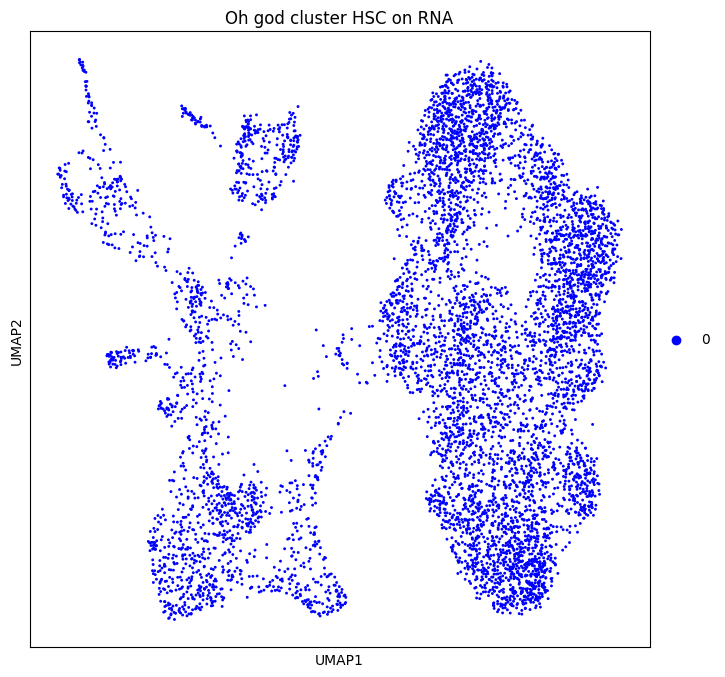

... storing 'test' as categorical
... storing 'celltype' as categorical


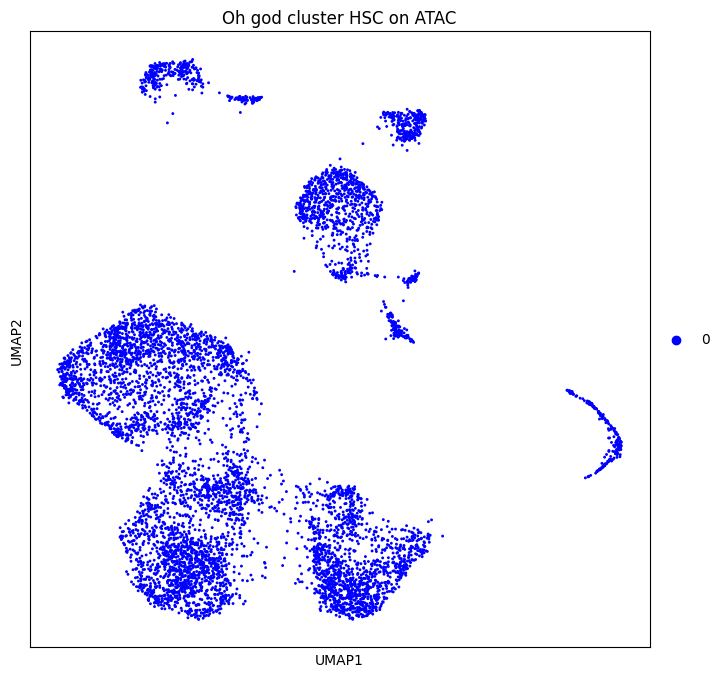

In [31]:
adata_rna_sub.obs['test'] = test_vec_rna
adata_atac_sub.obs['test'] = test_vec_rna

sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on RNA')

sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on ATAC')

... storing 'test' as categorical


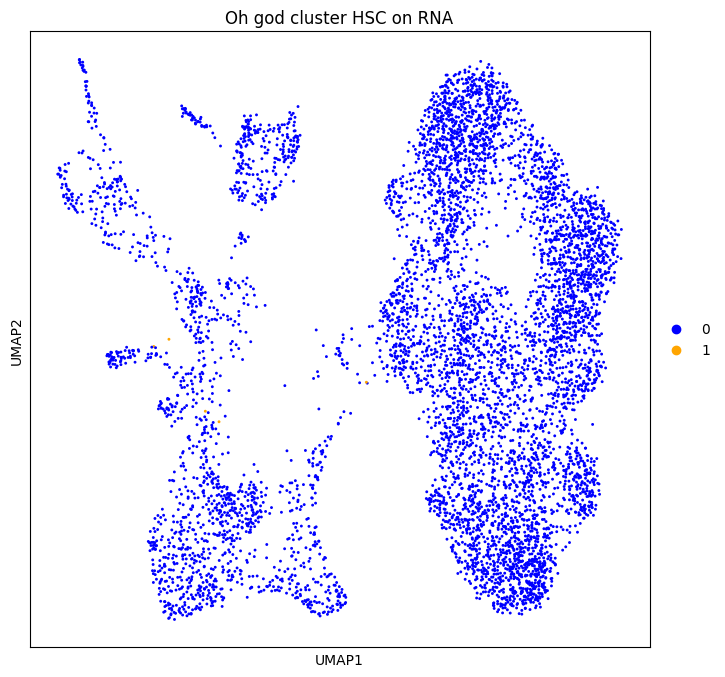

... storing 'test' as categorical


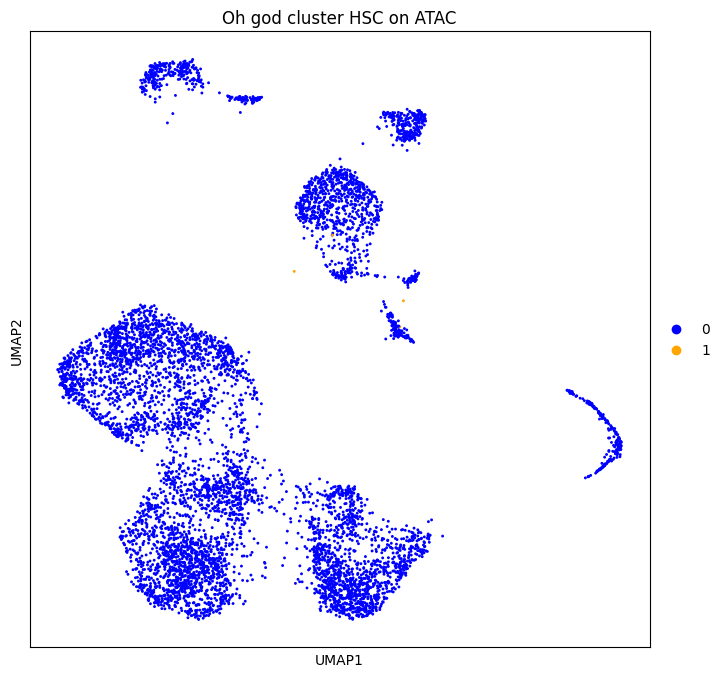

In [32]:
adata_rna_sub.obs['test'] = test_vec_atac
adata_atac_sub.obs['test'] = test_vec_atac

sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on RNA')

sc.pl.umap(adata_atac_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on ATAC')

RNA:
- 'HSPC/Lymph prog?': widly spread out in ATAC -> remove

ATAC:
- high count - T doublet? : CD4+ T activated

- 'pro - BORCS5': widly spread out in RNA -> remove

- CD14+ Mono: widly spread out -> remove

Potentially also remove cell clusters where oh god cells should not be included either way

Here, we remove the pro - BORCS5, since it seems to be hard to be associated with any specific cell type

In [33]:
remove_mask = adata_atac_sub[~adata_atac_sub.obs['leiden_final'].isin(['Oh god'])].obs_names

In [34]:
adata_rna_sub = adata_rna_sub[remove_mask]
adata_atac_sub = adata_atac_sub[remove_mask]

Add celltype for Oh god cells, where association is clear

In [35]:
new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    given_ct = adata_rna_sub.obs['celltype'][idx]
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    atac_ct = adata_atac_sub.obs['leiden_final'][idx]
    
    if given_ct == 'Oh god':
        if atac_ct == 'high count - T doublet?':
            new_celltype_ann.append('CD8+ T')
        # Below would be adding a label if celltype association is clear
        #elif rna_ct == 'G/M prog':
        #    new_celltype_ann.append('Lymph prog')
        else:
            new_celltype_ann.append('Oh god')
    else:
        new_celltype_ann.append(given_ct)

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_atac_sub.obs['celltype'] = final_ann_df

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [36]:
adata_rna_sub.obs['celltype'].value_counts()

CD8+ T                 1632
CD4+ T naive           1289
NK                      982
CD4+ T activated        709
CD14+ Mono              704
ILC                     367
Oh god                  245
CD16+ Mono              179
Erythroblast            136
B1 B                    127
Naive CD20+ B           121
cDC2                     89
MK/E prog                71
Reticulocyte             69
pDCs                     53
ID2-hi myeloid prog      41
Transitional B           40
HSC                      33
Proerythroblast          30
Lymph prog               28
HSPC/Mono prog           27
Plasma cell              13
Name: celltype, dtype: int64

### Remove unresolvable cells

Remove remaining Oh god cells

In [37]:
adata_rna_sub = adata_rna_sub[~adata_rna_sub.obs['celltype'].isin(['Oh god'])].copy()
adata_atac_sub = adata_atac_sub[~adata_atac_sub.obs['celltype'].isin(['Oh god'])].copy()

... storing 'celltype' as categorical


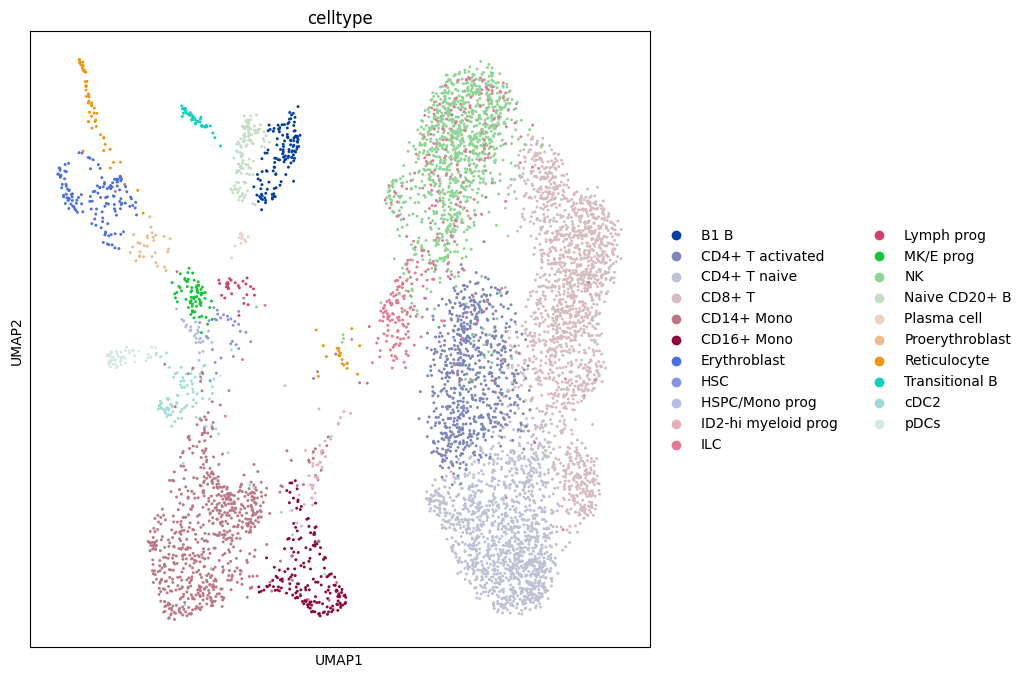

... storing 'celltype' as categorical


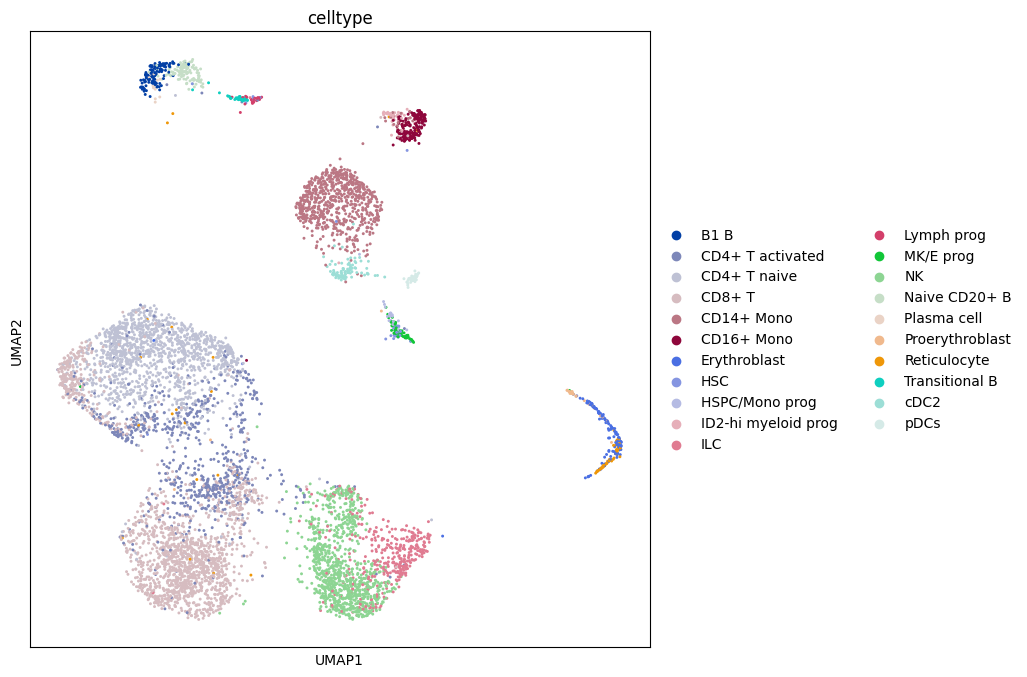

In [38]:
sc.pl.umap(adata_rna_sub, color='celltype')
sc.pl.umap(adata_atac_sub, color='celltype')

# ATAC object back to peaks

In [39]:
# Switch over peaks and gene activity
adata_atac_sub_peak = ad.AnnData(X = adata_atac_sub.obsm['peaks'],
                                 obs = adata_atac_sub.obs, 
                                 var=pd.DataFrame(index=adata_atac_sub.uns['peak_names']))

In [40]:
adata_atac_sub_peak.obsm['lsi_full'] = adata_atac_sub.obsm['lsi_full']
adata_atac_sub_peak.obsm['lsi_red'] = adata_atac_sub.obsm['lsi_red']
adata_atac_sub_peak.obsm['umap'] = adata_atac_sub.obsm['umap']
adata_atac_sub_peak.obsm['gene_activity'] = adata_atac_sub.X
adata_atac_sub_peak.uns['gene_activity_var_names'] = [str(i) for i in adata_atac_sub.var_names]

adata_atac_sub_peak.uns['neighbors'] = adata_atac_sub.uns['neighbors']
adata_atac_sub_peak.obsp['connectivities'] = adata_atac_sub.obsp['connectivities']
adata_atac_sub_peak.obsp['distances'] = adata_atac_sub.obsp['distances']

In [41]:
adata_atac_sub_peak

AnnData object with n_obs × n_vars = 6740 × 138781
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'corrected_barcodes', 'rna_ann', 'test', 'celltype'
    uns: 'gene_activity_var_names', 'neighbors'
    obsm: 'lsi_full', 'lsi_red', 'umap', 'gene_activity'
    obsp: 'connectivities', 'distances'

In [42]:
adata_atac_sub_peak.var_names

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456', 'chr1-585752-586647',
       'chr1-629497-630394', 'chr1-631263-632122', 'chr1-633515-634474',
       'chr1-778276-779191',
       ...
       'GL000219.1-90062-90937', 'GL000219.1-99257-100160',
       'GL000219.1-125068-125895', 'GL000219.1-132747-133579',
       'KI270731.1-4506-5403', 'KI270721.1-2091-2979',
       'KI270726.1-27152-28034', 'KI270726.1-41476-42297',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=138781)

# Trajectories

## RNA Trajectory

In [43]:
adata_rna_sub.obs['celltype'].value_counts()

CD8+ T                 1632
CD4+ T naive           1289
NK                      982
CD4+ T activated        709
CD14+ Mono              704
ILC                     367
CD16+ Mono              179
Erythroblast            136
B1 B                    127
Naive CD20+ B           121
cDC2                     89
MK/E prog                71
Reticulocyte             69
pDCs                     53
ID2-hi myeloid prog      41
Transitional B           40
HSC                      33
Proerythroblast          30
Lymph prog               28
HSPC/Mono prog           27
Plasma cell              13
Name: celltype, dtype: int64

In [44]:
rename_clust_dict = {
    'CD8+ T':'CD8+ T',
    'CD4+ T naive':'CD4+ T naive',
    'NK':'NK',
    'CD14+ Mono':'CD14+ Mono',
    'CD4+ T activated':'CD4+ T activated',
    'ILC':'ILC',
    'CD16+ Mono':'CD16+ Mono',
    'Erythroblast':'Erythroblast',
    'B1 B': 'B1 B',
    'Naive CD20+ B':'Naive CD20+ B',
    'cDC2':'cDC2',
    'MK/E prog':'MK/E prog',
    'pDCs':'pDCs',
    'Reticulocyte':'Normoblast',
    'Transitional B':'Transitional B',
    'Proerythroblast':'Proerythroblast',
    'HSPC/Mono prog':'HSPC/Mono prog',
    'HSC':'HSC',
    'Lymph prog':'Lymph prog',
    'Plasma cell':'Plasma cell',
    'ID2-hi myeloid prog':'ID2-hi myeloid prog'
}

In [45]:
# Note: this must be done in the same order as the categories above!
adata_rna_sub.rename_categories('celltype', [rename_clust_dict[ct] for ct in adata_rna_sub.obs['celltype'].cat.categories])

In [46]:
adata_rna_sub.obs['celltype'].value_counts()

CD8+ T                 1632
CD4+ T naive           1289
NK                      982
CD4+ T activated        709
CD14+ Mono              704
ILC                     367
CD16+ Mono              179
Erythroblast            136
B1 B                    127
Naive CD20+ B           121
cDC2                     89
MK/E prog                71
Normoblast               69
pDCs                     53
ID2-hi myeloid prog      41
Transitional B           40
HSC                      33
Proerythroblast          30
Lymph prog               28
HSPC/Mono prog           27
Plasma cell              13
Name: celltype, dtype: int64

In [47]:
adata_rna_ery = adata_rna_sub[adata_rna_sub.obs['celltype'].isin(['HSC', 'MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast'])].copy()

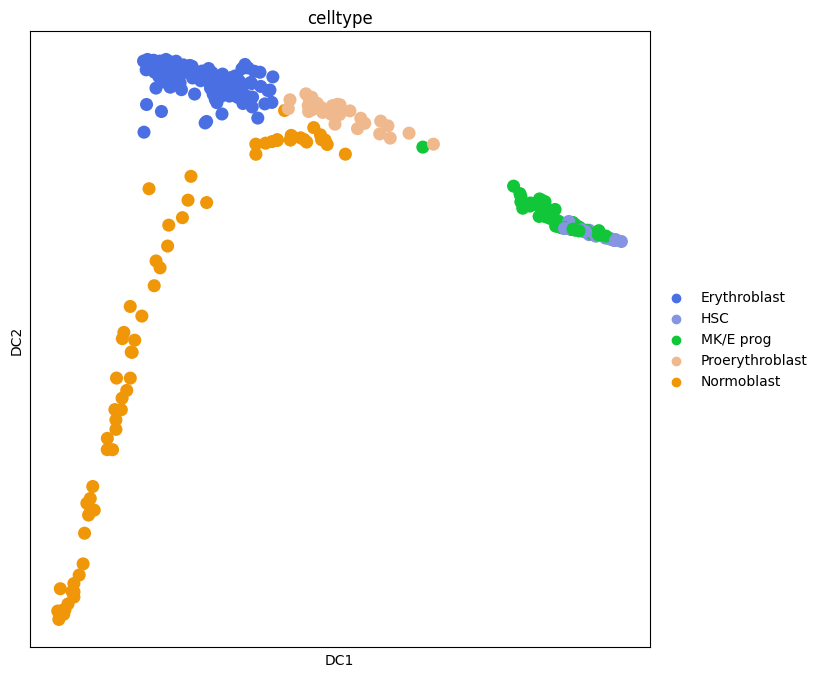

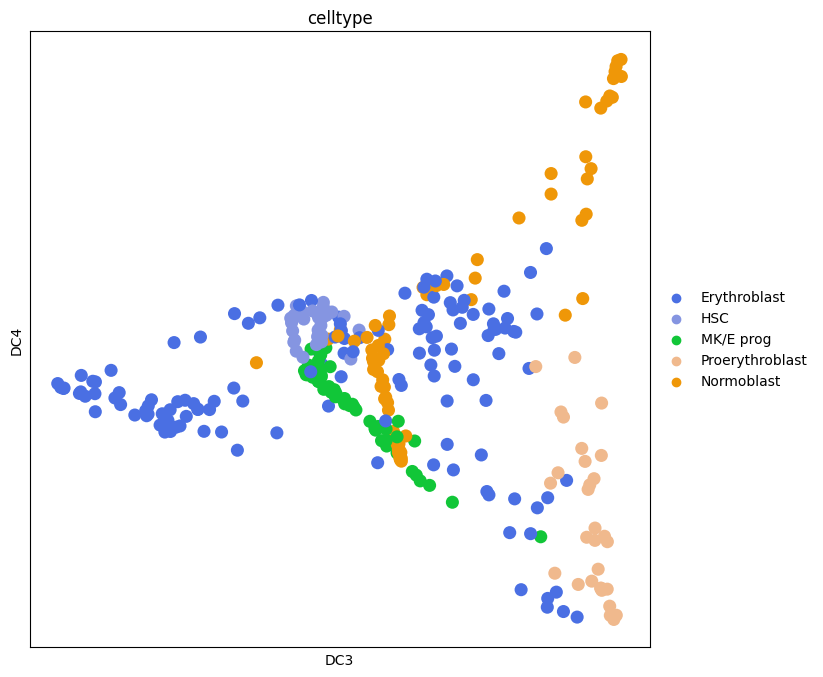

In [48]:
sc.pp.neighbors(adata_rna_ery)
sc.tl.diffmap(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='3,4', frameon=True)

In [49]:
# Get DC1 min, DC2 max cell as root (most outer stem cell like cell)
# NOTE: argmax() or argmin() often needs to be reassigned for each run

c1 = adata_rna_ery.obsm['X_diffmap'][:,1].argmin()
#c2 = adata_rna_ery.obsm['X_diffmap'][:,2].argmin()
c2 = c1

correct root cell: GGAACCACAGGCTACT-2


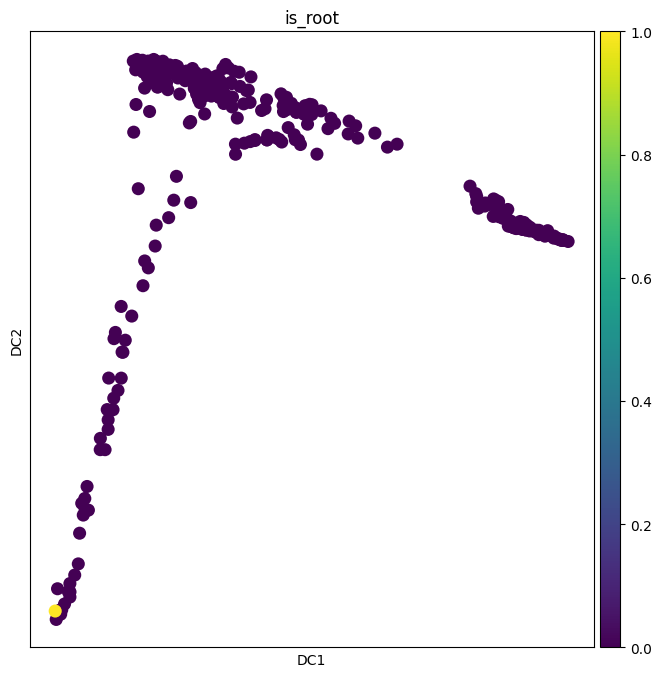

In [50]:
if c1 == c2:
    print(f'correct root cell: {adata_rna_ery.obs_names[c1]}')
    adata_rna_ery.uns['iroot'] = c1
    
    #check if correct
    adata_rna_ery.obs['is_root'] = [1 if idx==adata_rna_ery.obs_names[c1] else 0 for idx in adata_rna_ery.obs_names]
    sc.pl.diffmap(adata_rna_ery, color='is_root', components='1,2', frameon=True)
     

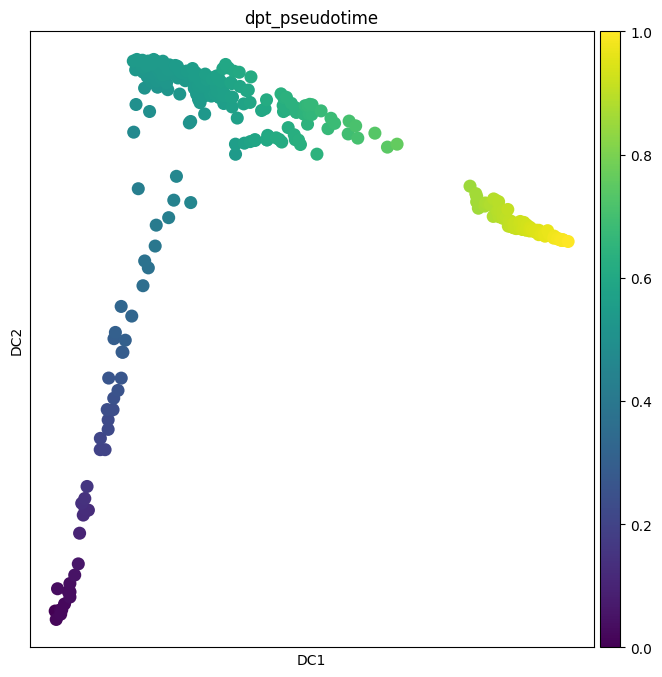

In [51]:
sc.tl.dpt(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [52]:
# Transfer back to full object
adata_rna_sub.obs['pseudotime_order_GEX'] = adata_rna_ery.obs['dpt_pseudotime']

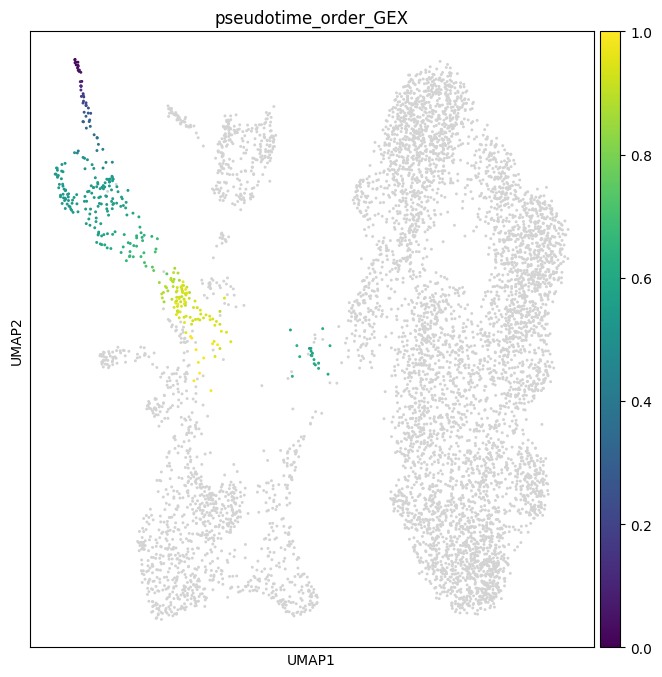

In [53]:
sc.pl.umap(adata_rna_sub, color='pseudotime_order_GEX')

## ATAC Trajectory

In [54]:
adata_atac_sub_peak.obs['celltype'].value_counts()

CD8+ T                 1632
CD4+ T naive           1289
NK                      982
CD4+ T activated        709
CD14+ Mono              704
ILC                     367
CD16+ Mono              179
Erythroblast            136
B1 B                    127
Naive CD20+ B           121
cDC2                     89
MK/E prog                71
Reticulocyte             69
pDCs                     53
ID2-hi myeloid prog      41
Transitional B           40
HSC                      33
Proerythroblast          30
Lymph prog               28
HSPC/Mono prog           27
Plasma cell              13
Name: celltype, dtype: int64

In [55]:
# Note: this must be done in the same order as the categories above!
adata_atac_sub_peak.rename_categories('celltype', [rename_clust_dict[ct] for ct in adata_atac_sub_peak.obs['celltype'].cat.categories])

In [56]:
#change reticulocyte to normoblast
adata_atac_sub_peak.obs['celltype'].value_counts()

CD8+ T                 1632
CD4+ T naive           1289
NK                      982
CD4+ T activated        709
CD14+ Mono              704
ILC                     367
CD16+ Mono              179
Erythroblast            136
B1 B                    127
Naive CD20+ B           121
cDC2                     89
MK/E prog                71
Normoblast               69
pDCs                     53
ID2-hi myeloid prog      41
Transitional B           40
HSC                      33
Proerythroblast          30
Lymph prog               28
HSPC/Mono prog           27
Plasma cell              13
Name: celltype, dtype: int64

In [57]:
adata_atac_ery = adata_atac_sub_peak[adata_atac_sub_peak.obs['celltype'].isin(['HSC', 'MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast'])].copy()
#adata_atac_ery = adata_atac_sub_peak[adata_atac_sub_peak.obs['celltype'].isin(['Proerythroblast', 'Erythroblast', 'Reticulocyte'])].copy()#

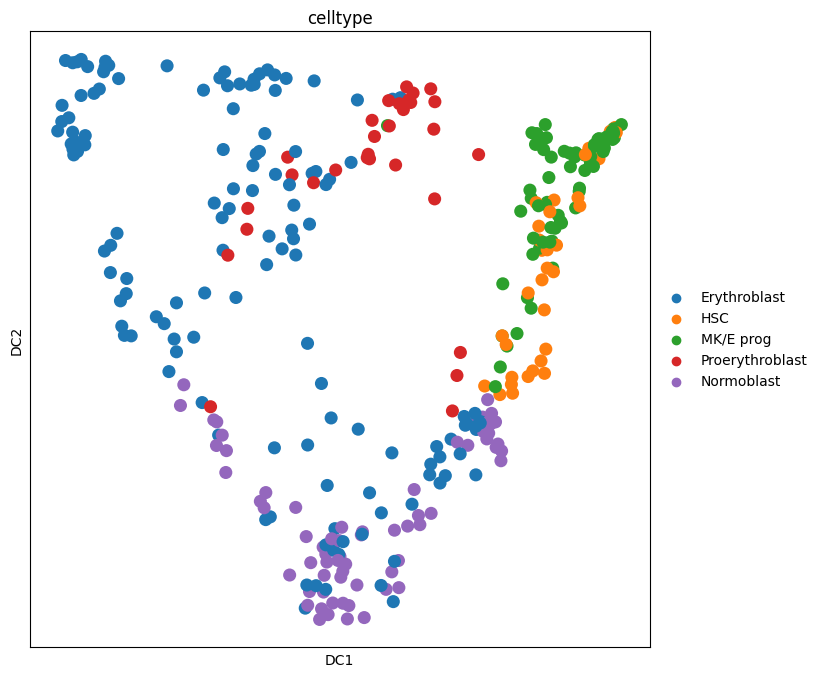

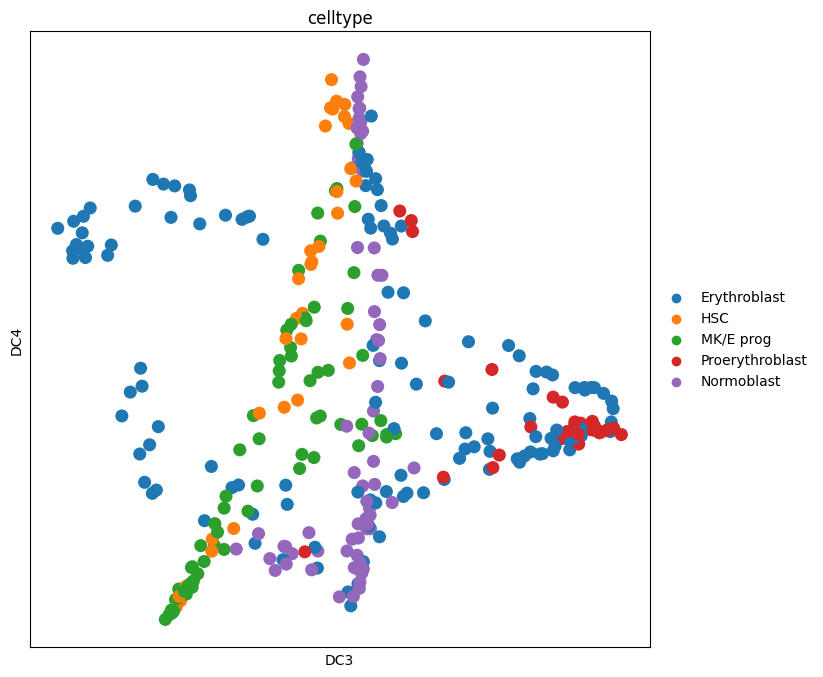

In [58]:
sc.pp.neighbors(adata_atac_ery, use_rep = 'lsi_red')
sc.tl.diffmap(adata_atac_ery)
sc.pl.diffmap(adata_atac_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_atac_ery, color='celltype', components='3,4', frameon=True)

correct root cell: ATATGCATCGATTTGA-2


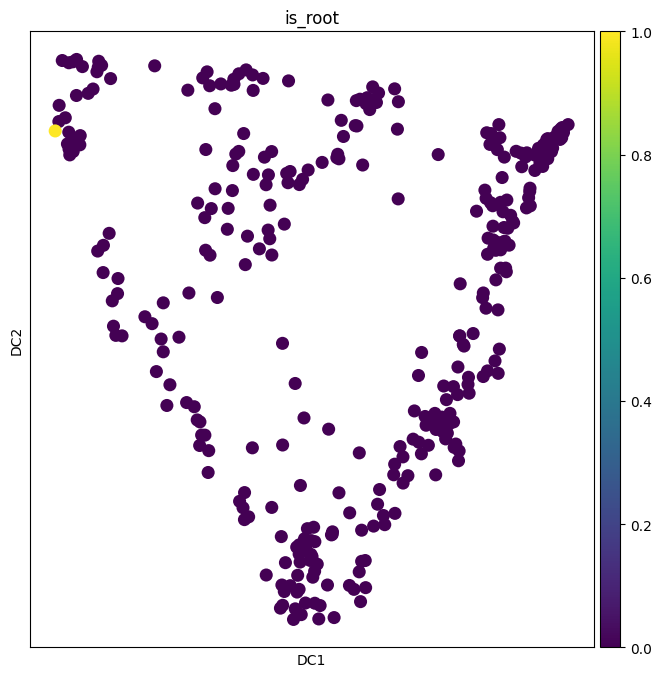

In [59]:
# Get DC1 min, DC2 max cell as root (should be the outer most stemm cell

c1 = adata_atac_ery.obsm['X_diffmap'][:,1].argmin()
c2 = c1

if c1 == c2:
    print(f'correct root cell: {adata_atac_ery.obs_names[c1]}')
    adata_atac_ery.uns['iroot'] = c1
    
    #check if correct
    adata_atac_ery.obs['is_root'] = [1 if idx==adata_atac_ery.obs_names[c1] else 0 for idx in adata_atac_ery.obs_names]
    sc.pl.diffmap(adata_atac_ery, color='is_root', components='1,2', frameon=True)

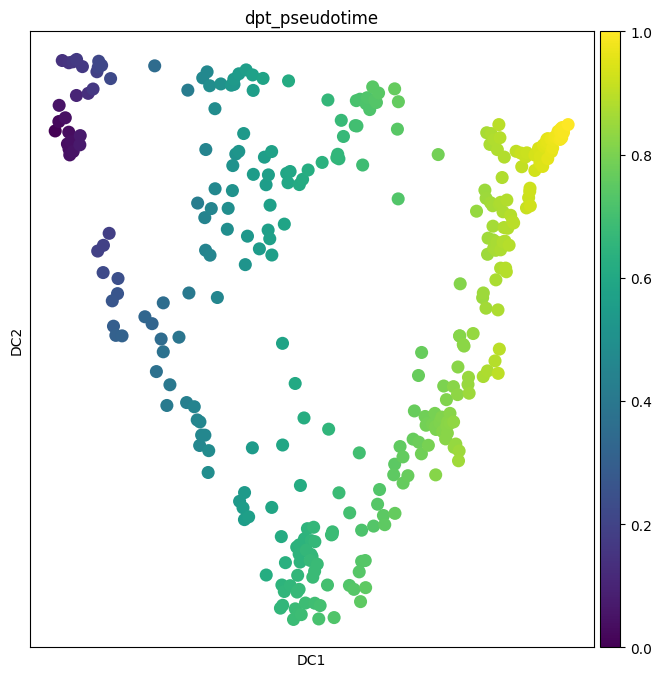

In [60]:
sc.tl.dpt(adata_atac_ery)
sc.pl.diffmap(adata_atac_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [61]:
# Transfer back to full object
adata_atac_sub_peak.obs['pseudotime_order_ATAC'] = adata_atac_ery.obs['dpt_pseudotime']

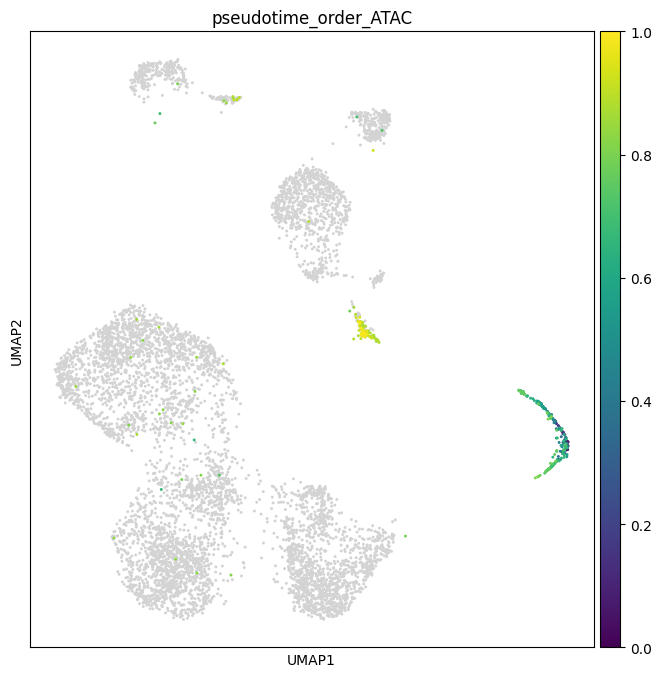

In [62]:
sc.pl.umap(adata_atac_sub_peak, color='pseudotime_order_ATAC')

## Write output

Save RNA data

In [63]:
# Check the object
adata_rna_sub

AnnData object with n_obs × n_vars = 6740 × 16946
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'test', 'celltype', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5_9sub_colors', 'neighbors', 'pca', 'umap', 'leiden_final_colors', 'atac_ann_colors', 'test_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [64]:
# Create slim rna adata
adata_rna_slim = ad.AnnData(X=adata_rna_sub.X,
                            obs=adata_rna_sub.obs[['n_genes_by_counts','pct_counts_mt',
                                                  'n_counts','n_genes','size_factors','phase',
                                                  'leiden_final','atac_ann','celltype','pseudotime_order_GEX']],
                           var=adata_rna_sub.var)

adata_rna_slim.obs = adata_rna_slim.obs.rename(columns={'celltype':'cell_type'})
adata_rna_slim.var['feature_types'] = 'GEX'

adata_rna_slim.uns = adata_rna_sub.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_rna_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_rna_slim.uns[col])

adata_rna_slim.obsm = adata_rna_sub.obsm
adata_rna_slim.varm = adata_rna_sub.varm
adata_rna_slim.obsp = adata_rna_sub.obsp
adata_rna_slim.layers['counts'] = adata_rna_sub.layers['counts']

In [65]:
adata_rna_slim

AnnData object with n_obs × n_vars = 6740 × 16946
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [66]:
pwd

'/home/jovyan/project/notebooks/s1d2_analysis'

In [67]:
# Save
adata_rna_slim.write_h5ad('/home/jovyan/project/s1d2_data/s1d2_rna_processed.h5ad')

... storing 'feature_types' as categorical


Save ATAC data

In [68]:
# Check the object
adata_atac_sub_peak

AnnData object with n_obs × n_vars = 6740 × 138781
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'corrected_barcodes', 'rna_ann', 'test', 'celltype', 'pseudotime_order_ATAC'
    uns: 'gene_activity_var_names', 'neighbors'
    obsm: 'lsi_full', 'lsi_red', 'umap', 'gene_activity'
    obsp: 'connectivities', 'distances'

In [69]:
adata_atac_sub_peak.var_names

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456', 'chr1-585752-586647',
       'chr1-629497-630394', 'chr1-631263-632122', 'chr1-633515-634474',
       'chr1-778276-779191',
       ...
       'GL000219.1-90062-90937', 'GL000219.1-99257-100160',
       'GL000219.1-125068-125895', 'GL000219.1-132747-133579',
       'KI270731.1-4506-5403', 'KI270721.1-2091-2979',
       'KI270726.1-27152-28034', 'KI270726.1-41476-42297',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=138781)

In [70]:
# Create slim atac adata
adata_atac_slim = ad.AnnData(X=adata_atac_sub_peak.X,
                            obs=adata_atac_sub_peak.obs[['nCount_peaks', 'atac_fragments',
                                                   'reads_in_peaks_frac', 'blacklist_fraction',
                                                   'nucleosome_signal', 'leiden_final', 'rna_ann',
                                                   'celltype', 'pseudotime_order_ATAC']])

adata_atac_slim.obs = adata_atac_slim.obs.rename(columns={'celltype':'cell_type'})
adata_atac_slim.var['feature_types'] = 'ATAC'

adata_atac_slim.uns = adata_atac_sub_peak.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_atac_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_atac_slim.uns[col])

adata_atac_slim.obsm = adata_atac_sub_peak.obsm
adata_atac_slim.obsp = adata_atac_sub_peak.obsp
adata_atac_slim.var_names = adata_atac_sub_peak.var_names

In [71]:
adata_atac_slim

AnnData object with n_obs × n_vars = 6740 × 138781
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'leiden_final', 'rna_ann', 'cell_type', 'pseudotime_order_ATAC'
    var: 'feature_types'
    uns: 'gene_activity_var_names', 'neighbors'
    obsm: 'lsi_full', 'lsi_red', 'umap', 'gene_activity'
    obsp: 'connectivities', 'distances'

In [72]:
adata_atac_slim.write_h5ad('/home/jovyan/project/s1d2_data/s1d2_atac_processed.h5ad')

... storing 'feature_types' as categorical


In [73]:
adata_atac_slim.var_names

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456', 'chr1-585752-586647',
       'chr1-629497-630394', 'chr1-631263-632122', 'chr1-633515-634474',
       'chr1-778276-779191',
       ...
       'GL000219.1-90062-90937', 'GL000219.1-99257-100160',
       'GL000219.1-125068-125895', 'GL000219.1-132747-133579',
       'KI270731.1-4506-5403', 'KI270721.1-2091-2979',
       'KI270726.1-27152-28034', 'KI270726.1-41476-42297',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=138781)